In [1]:
import pgmpy
import pyvis
import pandas as pd

import networkx as nx
import numpy as np
from operator import itemgetter, attrgetter
from networkx.algorithms import tree, community
from networkx.generators.ego import ego_graph
import matplotlib.pylab as plt
from pyvis.network import Network

A large social network of GitHub developers which was collected from the public API in June 2019. Nodes are developers who have starred at least 10 repositories and edges are mutual follower relationships between them. The vertex features are extracted based on the location, repositories starred, employer and e-mail address. The task related to the graph is binary node classification - one has to predict whether the GitHub user is a web or a machine learning developer. This target feature was derived from the job title of each user.

In [2]:
# stanford dataset network site https://snap.stanford.edu/data

path_edges = "../data/github_users_network/musae_git_edges.csv"

path_target = "../data/github_users_network/musae_git_target.csv"


def reader(path_reader, path_target):
    df_edges = pd.read_csv(path_edges)
    df_target = pd.read_csv(path_target)
    return df_edges, df_target

def create_network_from_df(df):
    df = df.rename(columns={df.columns[0]: 'source', df.columns[1]: 'target'})
    Graphtype = nx.Graph()
    G = nx.from_pandas_edgelist(df,  create_using=Graphtype)
    return G
    #print(nx.info(G))
    #G.edges
    
    
def get_edge_list(G, sort=True):
    if sort:
        # sort by node 1
        sorted_edges = sorted(G.edges(), key=lambda x: x[0], reverse=True)
        return sorted_edges
    else:
        return list(G.edges())


def list_duplicate_edges(G):
    dup = list(duplicates(get_edge_list(G)))
    if len(dup) > 0:
        print(f"{len(dup)} duplicates found")
    return dup
    
def remove_nodes_with_low_degree(G, n):
    degree_sorted = sorted(G.degree(), key=lambda x: x[1], reverse=True)
    #keep top n nodes 
    node_list_remove = [node for node, v in degree_sorted[n::]]
    G.remove_nodes_from(node_list_remove)
    return G


def draw_network(G, notebook=True, physics=True):
    if notebook:
        nt = Network('500px', '500px',notebook=True)
    else:
        nt = Network('500px', '500px')
    nt.from_nx(G)
    if physics:
        nt.show_buttons(filter_=['physics'])
    return nt

def max_spanning_tree(G, algorithm="kruskal"):
    mst = tree.maximum_spanning_edges(G, algorithm=algorithm, data=False)
    edge_list = list(mst)
    G = nx.Graph()
    G.add_edges_from(edge_list)  # using a list of edge tuples
    return G
    
def compute_degree_betweeness(G):
    degree_dict = dict(G.degree(G.nodes()))
    betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
    #eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
    return degree_dict, betweenness_dict
    
    
def community_detection(G):
    communities = community.greedy_modularity_communities(G)
    modularity_dict = {} # Create a blank dictionary
    for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
        for name in c: # Loop through each person in a community
            modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

    return communities, modularity_dict
    
    
def set_attributes(G, **kwargs):
    for key in kwargs.keys(): 
        nx.set_node_attributes(G, kwargs[key],key)
    return G

    
def top_betweeness_nodes_with_attributes(G, top_n=20):
    betweenness_dict = nx.get_node_attributes(G,'betweeness')
    sorted_betweenness = sorted(betweenness_dict.items(), key=itemgetter(1), reverse=True)
    #First get the top n nodes by betweenness as a list
    top_betweenness = sorted_betweenness[:top_n]
    degree_list = []
    modularity_list = []
    node_id = []
    betweenness_list = []
    #Then find and print their corresponding attributes: degree,  modularity
    for tb in top_betweenness: # Loop through top_betweenness
        degree = nx.get_node_attributes(G,'degree')[tb[0]] # Use degree_dict to access a node's degree
        modularity = nx.get_node_attributes(G,'modularity')[tb[0]]
        degree_list.append(degree)
        modularity_list.append(modularity)
        betweenness_list.append(tb[1])
        node_id.append(tb[0])
        #print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree, "| Modularity", modularity)
    return pd.DataFrame({'id':node_id, 'betweeness': betweenness_list, 
                         'Degree': degree_list, 'Modularity': modularity_list})
        
def shortest_path(G, source_id, target_id):
    shortest_path = nx.shortest_path(G, source=source_id, target=target_id)
    print("Shortest path between user1 and user2:", shortest_path)
    return shortest_path

def plot_community_class_count(communities):
    count_list = []
    class_list = []
    for i,c in enumerate(communities):
        class_list.append(i)
        count_list.append(len(list(c)))

    df = pd.DataFrame({'class':class_list, 'count':count_list})
    df.plot.bar(x='class', y='count')
    return df

def connected_components(G, subgraph=False, node_list=None):
    # use nx.connected_components to get the list of components,
    # then use the max() command to find the largest one:
    components = nx.connected_components(G)
    print(components)
    largest_component = max(components, key=len)
    return components, largest_component

def plot_subgraph(G, node_list):
    subgraph = G.subgraph(node_list)
    diameter = nx.diameter(subgraph)
    print("Network diameter of largest component:", diameter)
    nt = draw_network(subgraph)
    return nt

def plot_ego_network(G, n, radius):
    """
    plot ego network around a node n depending
    on radius setting i.e. only include upto
    n nodes directly or indirectly connected to
    this node
    """
    ego_nx = ego_graph(G, n, radius=radius)
    nt = draw_network(ego_nx)
    return nt
    
def export_graph(G, path='../data/github_network.gexf'):
    nx.write_gexf(G, path)

#### Read in dataset and plot graph after restriocting to top 1000  nodes with higest degree

The  lets prune this by running max weighted spanning tree algo

In [3]:

df_edges, df_target = reader(path_edges, path_target) 
main_nx = create_network_from_df(df_edges)
main_nx = remove_nodes_with_low_degree(main_nx, n=300)
nt= draw_network(main_nx)
nt.show('original_net_top_300_degree.html')

#### Pruned network - Max Weighted Spanning tree

In [4]:
prune_nx =  max_spanning_tree(main_nx, algorithm="kruskal")
nt= draw_network(prune_nx)
nt.show('mst_network.html')

#### Compute metrics and list metrics for top betweeness centralty nodes

In [55]:
degree, betweenness = compute_degree_betweeness(prune_nx)

communities, modularity = community_detection(prune_nx)


metrics = {'degree': degree, 'betweeness': betweenness, 'modularity': modularity}
prune_nx = set_attributes(prune_nx, **metrics)
metrics = top_betweeness_nodes_with_attributes(prune_nx, top_n=1000)
metrics


,id,betweeness,Degree,Modularity
0,27803,0.923571,215,0
1,29982,0.467868,52,1
2,21142,0.141950,22,2
3,20363,0.026621,5,3
4,31890,0.020000,4,4
...,...,...,...,...
295,20978,0.000000,1,4
296,29892,0.000000,1,1
297,37557,0.000000,1,1
298,7562,0.000000,1,2


check out who these top 3 people are by joining on target df


In [17]:
top_nodes_labels = top_metrics.iloc[0:3, :].merge(df_target, on='id')[['id', 'name', 'ml_target']]

Shortest path between user1 and user2: [27048, 20363, 29982, 18562]


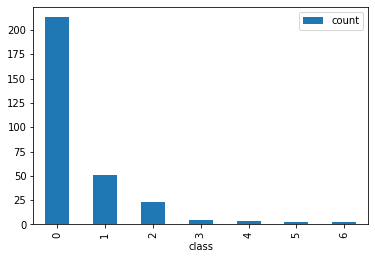

In [7]:

shortest = shortest_path(prune_nx, source_id=27048, target_id=18562)
community_count = plot_community_class_count(communities)

#### subgraph with commuity groups 

In [64]:
# this returns the entire graph as only one component in this graph 
plt.rcParams['figure.figsize'] = [15, 15]
#fig, ax = plt.subplots(1,2)
#ax
components, largest_component = connected_components(prune_nx)
nt = plot_subgraph(prune_nx, largest_component)
mapper = {0:'red', 1: 'yellow', 2: 'green', 3:'orange', 4: 'brown', 5: 'purple', 6:'pink'}

node_id_list = list(metrics['id'].values)

for node in nt.nodes:
    if node['id'] in node_id_list:
        mod = metrics.loc[metrics['id']== node['id'], 'Modularity'].values[0]
        node['color'] = mapper[mod]
        
nt.show('subgraph.html')

<generator object connected_components at 0x7fd8d0ed2740>
Network diameter of largest component: 6


pick node with highest betweeness centrality and plot ego network with radius 2 

In [65]:
node_id = 27803

nt = plot_ego_network(prune_nx, node_id, radius = 1)
for node in nt.nodes:
    if node['id'] == node_id:
        mod = metrics.loc[metrics['id']== node['id'], 'Modularity'].values[0]
        node['color'] = mapper[mod]
nt.show('ego.html')

In [23]:
from networkx.algorithms import node_classification

for node in .nodes:
    if node['id'] == 29982:
        node['label'] = top_nodes_labels.loc[top_nodes_labels['id'] == node['id'], 'ml_target']
node_classification.harmonic_function(nt)


AttributeError: 'Network' object has no attribute 'is_directed'